In [7]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import Imputer 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import model_selection
from sklearn import metrics
from textblob import TextBlob
import pickle
from sklearn.externals import joblib
from scipy.stats import spearmanr, pearsonr
from sklearn.manifold import TSNE
#from bokeh.plotting import figure, show
#from bokeh.io import push_notebook, output_notebook
#from bokeh.models import ColumnDataSource, LabelSet
%load_ext autoreload
%autoreload 2
%matplotlib inline
from random import randint
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
import gensim
#output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dat = pd.read_csv('/Users/rithika/Documents/247ai/Hello Fresh_2018-05-01_2018-05-31_UK.csv')

# Data cleaning

In [3]:
#cleaning input data to get predictor values and target
def prepare_data(fname):
    filename = os.path.join('/Users/rithika/Documents/247ai/datasets', fname)
    if os.path.isfile(filename):
        dat = pd.read_csv(filename)
    else:
        print("no such file exists at this time")
    dat['Adcopy']=dat['Headline 1']+' '+dat['Headline 2']+' '+dat['Description']
    dat = dat[['Adcopy','Clicks']]
    dat = dat[pd.notnull(dat['Adcopy'])]
    dat['Adcopy'] = dat['Adcopy'].replace('http\S+|www.\S+', '', regex=True)
    dat['Adcopy'].replace('[™!®"#\'()*+,-./:;<=>?@\&[\]^_`{|}~’”“′‘\\\%0123456789£]',' ',inplace=True,regex=True)
    dat['Adcopy'].replace('  ',' ',inplace=True,regex=True)
    dat['Adcopy'].replace('   ',' ',inplace=True,regex=True)
    dat['Adcopy'].replace('  ',' ',inplace=True,regex=True)
    dat['Adcopy'] = dat['Adcopy'].str.lower()
    #stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    stop = stopwords.words('english')
    dat['Adcopy'] = dat['Adcopy'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(str(word)) for word in x.split()]))
    #dat['cle'] = dat['Adcopy'].apply(lambda x: ' '.join([stemmer.stem(str(word)) for word in x.split()]))
    dat['Copy'] = dat['Adcopy'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return dat[['Copy','Clicks']]

In [4]:
#data = prepare_data('Hello Fresh_2018-05-01_2018-05-31_UK.csv')

In [5]:
data = prepare_data('Digitonomy_2018-06-01_2018-06-30.csv')

In [8]:
#getting unique values 
datum = data.groupby('Copy')['Clicks'].mean().reset_index()
#datum = data.groupby('Copy')['Clicks'].sum().reset_index()
#spellcorrector - takes really long time
#datum['Copy'] = datum['Copy'].apply(lambda s: TextBlob(s).correct()) #already being done when calculating vectors to reduce cpu usage
datu = datum.groupby('Copy')['Clicks'].mean().reset_index()
cleaned_data = datu['Copy'] #predictor values
result = datu['Clicks'] #target

In [9]:
len(cleaned_data)

16991

In [15]:
len(a)

16991

# Word2vec analysis

In [16]:
#loading googlenews vec
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/rithika/Documents/247ai/GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
#prints words from the dataset which is not present in google news vec
nokey = list()
for sentence in cleaned_data:
    for word in sentence.split(' '): 
        if word not in model:
            if word not in nokey:
                nokey.append(word)
                
print(len(nokey))
print(nokey)

130
['a', 'fastcheck', 'anygator', 'aoneloans', 'quickcheck', 'unfordable', 'autoloans', 'specialise', 'catalogue', 'natychmiastowa', 'decyzja', 'gotówka', 'aplikuj', 'cleverloans', 'creditloans', 'balmoral', 'bambooloans', 'besthort', 'bestloans', 'blackheath', 'bluesea', 'booyacasha', 'centre', 'corydon', 'to', 'callcredit', 'cardsmart', 'cashadvance', 'cashadvances', 'cashboost', 'cashconverter', 'cashflex', 'cashfloat', 'cashloans', 'cashnetusa', 'cashngo', 'cheaploans', 'grm', 'miesięcy', 'creditscore', 'dailyloan', 'digitonomy', 'experian', 'eyford', 'flexcash', 'livecheck', 'eligibity', 'kabayan', 'kredytbank', 'kredyty', 'ladderloans', 'ladyloans', 'liquidloans', 'gurantor', 'barrington', 'fordham', 'fortudent', 'gloucester', 'middlesbrough', 'grimesby', 'pachy', 'safetynet', 'tydfil', 'scunthorpe', 'skelmersdale', 'stockport', 'organise', 'walsall', 'oldtudents', 'loanmatch', 'loanonaphone', 'loansathome', 'luzon', 'microlend', 'minicredit', 'mobilequid', 'moneybarn', 'moneylo

In [20]:
# a list of random float values within a range
def sample_floats(low, high, k=1):
    result = []
    seen = set()
    for i in range(k):
        x = random.uniform(low, high)
        while x in seen:
            x = random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

In [21]:
#generates vector array for words not in googlenews vec
def gen_arr():
    c = [0] * 300
    dup = sample_floats(-0.001, 0.001, 300)
    r = np.random.randint(5, 30)
    for i in range(r):
        ind = np.random.randint(0, len(c) - 1)
        c[ind] = np.random.choice(dup)
    return c 

In [22]:
#getting the words not present in google model
def get_valvec(data):
    nokey = list()
    my_dict = {}
    for sentence in data:
        for word in sentence.split(' '): 
            if word not in model: 
                if word not in nokey: #for words not present    
                    nokey.append(word)
                    ne = gen_arr()
                    my_dict[word] = ne
    return my_dict

In [23]:
#dictionary of words not present in google with their vecs 
extra_vec = get_valvec(cleaned_data)

In [24]:
len(extra_vec['fortudents'])

300

In [25]:
#getting feature vectors for hello fresh
def get_vectors(data):
    in_arr = []
    for sentence in data:
        n_arr = []
        for word in sentence.split(' '): 
            arr = []
            try:
                for single in model[word]:
                    arr.append(single)
            except ValueError:
                print("Value error")
            except KeyError:
                n_w = word.title()
                nn_w = textblob.Word(word).correct()
                if n_w in model:
                    try:
                        for single in model[n_w]:
                            arr.append(single)
                    except ValueError:
                        print("Value error")
                elif nn_w in model:
                    try:
                        for single in model[nn_w]:
                            arr.append(single)
                    except ValueError:
                        print("Value error")
                else:
                    v = extra_vec.get(word)
                    for i in v:
                        arr.append(i)
            n_arr.append(arr)
            arry = []
            arry = np.sum(n_arr,axis=0)
        in_arr.append(arry)   
    return in_arr

In [26]:
res = get_vectors(cleaned_data)

In [27]:
len(res)

16991

In [28]:
len(res[0])

300

In [29]:
def interactive_tsne(text_labels, en_coded):
    '''makes an interactive scatter plot with text labels for each point'''

    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(en_coded)

    plt.rcParams['figure.figsize'] = [10, 10]
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.show()

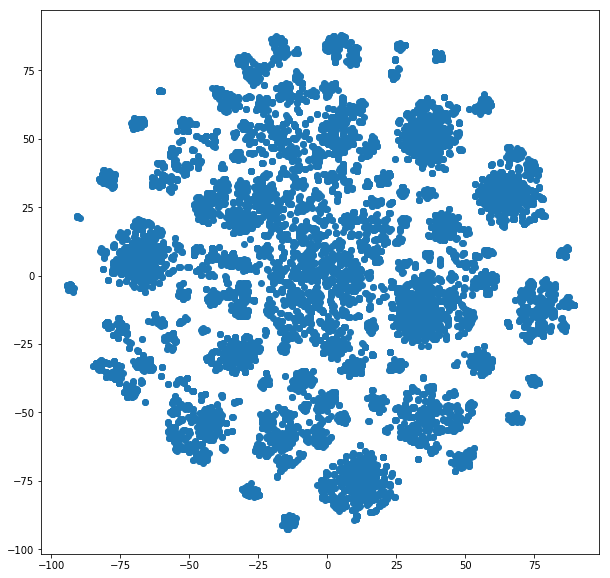

In [30]:
interactive_tsne(a,res)

In [31]:
x = np.array(res).tolist()
X = np.array(x)
y = np.array(result)

In [32]:
X

array([[ 0.78378296,  0.40722656, -0.47625732, ...,  0.20324707,
        -0.36560822, -0.76379395],
       [ 0.79159546,  0.64257812, -0.44500732, ...,  0.36376953,
        -0.34125519, -0.90673828],
       [ 0.72065735,  0.41113281, -0.58270264, ...,  0.29833984,
        -0.42554474, -0.58154297],
       ...,
       [-0.17807007,  0.0524292 , -0.36889648, ...,  0.74804688,
        -1.00177002, -0.20336914],
       [-0.2515564 ,  0.22424316, -0.20904541, ...,  0.56616211,
        -0.95465851, -0.71386719],
       [-0.2833252 ,  0.29620361,  0.78289795, ...,  0.01556396,
        -0.28823853,  0.39294434]])

In [33]:
y

array([0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
       0.        ])

In [34]:
X.shape

(16991, 300)

In [35]:
y.shape

(16991,)

# 5-fold cross validation

In [36]:
#kfold
kf = model_selection.KFold(n_splits=5) 
kf.get_n_splits(X)
print(kf) 

KFold(n_splits=5, random_state=None, shuffle=False)


In [37]:
#creating instance of RFRegressor 
model1 = RandomForestRegressor(n_estimators=500,max_features='log2',n_jobs=-1,min_samples_leaf=60)

In [38]:
#cross val score
#scores = model_selection.cross_val_score(model1, X, y, cv = 5, scoring ='neg_mean_squared_error')
#print(scores)

In [39]:
#cross val split with score and r2
for train_index, test_index in kf.split(X):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [40]:
#training
model1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=60, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
#evaluating
y_pred = model1.predict(X_test)

In [46]:
#monotonic relationship as the relation between the variables is non linear
spearman = spearmanr(y_test, y_pred)
pearson = pearsonr(y_test, y_pred)
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data pearson correlation: {pearson[0]:.3}')

Test data Spearman correlation: 0.101
Test data pearson correlation: 0.084


In [48]:
print('MSE')
print(metrics.mean_squared_error(y_test, y_pred)) #mean square error
print('R2')
print(metrics.r2_score(y_test, y_pred)) #r2 score
print('MAE')
print(metrics.mean_absolute_error(y_test, y_pred)) #mae
print('Variance Score')
print(metrics.explained_variance_score(y_test, y_pred)) #mape

MSE
2.951052999586395
R2
0.002872053449012313
MAE
0.4152644667776113
Variance Score
0.005028402585720015
